## import

In [1]:
import pandas as pd
from smds import SMDS
import IPython.display as ipd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import shuffle
from utils import min_max_normalization, TestModel
from keras import models, layers

## data

In [2]:
# load labels
data = pd.read_csv("./data/gtzan/features_30_sec.csv")
genres = data[["filename", "label"]]
Y = data["label"]

In [3]:
# load preprocessed data
smd = SMDS()
smd_data = smd.load("./data/smds/smds_13.csv")
smd_tempo = smd.load_tempo("./data/smds/smds_13_tempo.csv")
ipd.display(smd_data)
ipd.display(smd_tempo)

n_mfcc                           0                                             \
stat                      kurtosis       max       mean     median        min   
id  filename        tick                                                        
0   blues.00000.wav 0    -0.921429 -0.602207  -4.116866  -4.102283  -7.520702   
                    1    -1.034314 -1.877029  -7.598314  -7.186878 -13.353165   
                    2    -1.572501 -0.969917  -4.778881  -5.134876  -8.422367   
                    3    -0.464004 -6.557148 -19.352211 -13.589458 -44.356602   
                    4    -1.543346 -3.608807  -9.907966 -11.096891 -15.579109   
...                            ...       ...        ...        ...        ...   
999 rock.00099.wav  125  -1.668841 -6.418808  -8.240566  -8.720350  -9.642128   
                    126  -0.565443 -6.335140  -7.947320  -8.316345  -8.830395   
                    127  -1.263555 -7.196236  -7.737393  -7.752090  -8.294815   
                    128  -0.988667 -6.559055  -7.195686  -7.254095  -7.784954   
                    129   0.269860  0.000000  -1.463675   0.000000  -7.539124   

n_mfcc                                                1                        \
stat                          skew        std  kurtosis        max       mean   
id  filename        tick                                                        
0   blues.00000.wav 0     0.075946   2.036903  0.772538  -5.987366  -7.507081   
                    1    -0.174034   3.668512  0.112355  -4.566875  -5.301490   
                    2     0.114478   2.887686 -1.140482  -5.294666  -6.178790   
                    3    -1.017900  13.109632 -0.113993  -5.659710  -6.246984   
                    4     0.186728   4.365551 -0.444909  -5.034054  -6.183269   
...                            ...        ...       ...        ...        ...   
999 rock.00099.wav  125   0.288957   1.312025 -1.685759 -11.284740 -16.591238   
                    126   0.939037   0.814353  0.135143 -10.887753 -13.876005   
                    127   0.007978   0.383713  0.305037 -11.849773 -13.116172   
                    128   0.295401   0.383454 -0.891905 -12.233089 -13.124200   
                    129  -1.504257   2.929015  0.256183   0.000000  -2.852111   

n_mfcc                    ...         11                             12  \
stat                      ...        min      skew        std  kurtosis   
id  filename        tick  ...                                             
0   blues.00000.wav 0     ... -60.223705 -1.252348   8.094678 -0.558997   
                    1     ... -39.332470 -0.483045   3.570479  0.491824   
                    2     ... -44.687153 -0.152334   6.106122 -1.602251   
                    3     ... -28.273235 -0.827198   2.190228  0.502444   
                    4     ... -46.660244 -0.598231   8.158568  1.594014   
...                       ...        ...       ...        ...       ...   
999 rock.00099.wav  125   ... -32.267956  0.229043   2.567013 -1.421341   
                    126   ... -35.265717  0.395222   3.551404  0.340641   
                    127   ... -26.069447 -0.175981   0.682385 -0.081579   
                    128   ... -28.157679 -0.633861   1.239221 -0.325619   
                    129   ... -26.403402 -1.503891  10.270678  0.283285   

n_mfcc                                                                \
stat                            max       mean     median        min   
id  filename        tick                                               
0   blues.00000.wav 0    -31.908342 -40.000139 -39.760805 -48.561104   
                    1    -28.242262 -34.864012 -33.765718 -47.739788   
                    2    -27.690639 -31.491880 -30.364546 -36.691635   
                    3    -32.313374 -43.576982 -40.048849 -72.330002   
                    4    -29.337311 -42.734724 -41.277388 -72.304787   
...                             ...        ...        ...        ...   
999 rock.00099.wav  125  -23.87

,filename,tempo
0,blues.00000.wav,123.046875
1,blues.00001.wav,107.666016
2,blues.00002.wav,161.499023
3,blues.00003.wav,172.265625
4,blues.00004.wav,135.999178
...,...,...
995,rock.00095.wav,103.359375
996,rock.00096.wav,117.453835
997,rock.00097.wav,129.199219
998,rock.00098.wav,112.347147


In [4]:
def prepare_data(data: pd.DataFrame):
    grouped = data.groupby(by="id")
    
    cnn_data = [i for _, i in grouped]
    # cnn_data = np.expand_dims(cnn_data, axis=-1)
    return np.array(cnn_data)

def prepare_tempo_data(data: pd.DataFrame):
    tempo_data = [i for i in data["tempo"]]
    return np.array(tempo_data)
    

In [5]:
X_STAT = prepare_data(smd_data)
X_TEMPO = prepare_tempo_data(smd_tempo)
X_STAT, X_TEMPO, Y = shuffle(X_STAT, X_TEMPO, Y, random_state=1)
X_STAT.shape, X_TEMPO.shape, Y.shape
# 1000  songs
# 130   splits
# 91    statistical features (13 tracks * 7 features)
# 1     for CNN channel

((1000, 130, 91), (1000,), (1000,))

In [6]:
# 將 NaN 替換為 0，無窮大替換為合理的值

X_STAT = np.nan_to_num(X_STAT, nan=0.0, posinf=1.0, neginf=-1.0)
print(np.isnan(X_STAT).any())
print(np.isinf(X_STAT).any()) 

X_TEMPO = np.nan_to_num(X_TEMPO, nan=0.0, posinf=1000.0, neginf=0.0)
print(np.isnan(X_TEMPO).any())
print(np.isinf(X_TEMPO).any())

False
False
False
False


## Model 1

In [7]:
def build_encoder(input_shape: tuple, output_shape: int):
    # input_shape: (spilts, statistifics)
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=3, activation='sigmoid', padding='same')(input_layer)
    x = layers.Conv1D(128, kernel_size=3, activation='sigmoid', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='sigmoid')(x)
    x = layers.Dense(128, activation='sigmoid')(x)
    x = layers.Dense(32, activation='sigmoid')(x)
    x = layers.Dense(16, activation='sigmoid')(x)
    features = layers.Dense(output_shape, activation='sigmoid')(x)
    return models.Model(inputs=input_layer, outputs=features, name="encoder")

encoder = build_encoder((X_STAT.shape[1], X_STAT.shape[2]), 16)
encoder.summary()
encoder.output_shape

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 130, 91)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 130, 64)        │        17,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 130, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16640)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,520,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,633,024 (32.93 MB)

 Trainable params: 8,633,024 (32.93 MB)

 Non-trainable params: 0 (0.00 B)

(None, 16)

In [8]:
def build_decoder(input_shape: tuple, output_shape: tuple):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Dense(output_shape[0] * 128, activation='sigmoid')(input_layer)
    x = layers.Reshape((output_shape[0], 128))(x)
    x = layers.Conv1DTranspose(64, kernel_size=3, activation='sigmoid', padding='same')(x)
    reconstructed = layers.Conv1D(output_shape[1], kernel_size=3, activation='sigmoid', padding='same')(x)
    return models.Model(inputs=input_layer, outputs=reconstructed, name='decoder')

# input_shape     -> int
# (input_shape)   -> int
# (input_shape, ) -> tuple
decoder = build_decoder((16, ), (X_STAT.shape[1], X_STAT.shape[2]))
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16640)          │       282,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 130, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 130, 64)        │        24,640 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 130, 91)        │        17,563 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 325,083 (1.24 MB)

 Trainable params: 325,083 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
def build_preprocessor(data):
    normalizer = layers.Normalization()
    normalizer.adapt(data) # fit
    return normalizer

In [10]:
def build_autoencoder(input_shape, latent_dim, normalizer):
    # latent_dim: encoder output shape
    encoder = build_encoder(input_shape, latent_dim)
    decoder = build_decoder((latent_dim, ), input_shape)
    
    input_layer = layers.Input(shape=input_shape)
    normalized_data = normalizer(input_layer)
    features = encoder(normalized_data)
    reconstructed = decoder(features)
    
    autoencoder = models.Model(inputs=input_layer, outputs=reconstructed, name="autoencoder")
    return autoencoder

normalizer = build_preprocessor(X_STAT)
autoencoder = build_autoencoder(X_STAT.shape[1:], 8, normalizer)
autoencoder.summary(expand_nested=True)
    

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 130, 91)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 130, 91)        │           183 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 8)              │     8,632,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer_2 (InputLayer) │ (None, 130, 91)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_3 (Conv1D)          │ (None, 130, 64)        │        17,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_4 (Conv1D)          │ (None, 130, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ flatten_1 (Flatten)        │ (None, 16640)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_6 (Dense)            │ (None, 512)            │     8,520,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_7 (Dense)            │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_8 (Dense)            │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_9 (Dense)            │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_10 (Dense)           │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 130, 91)        │       191,963 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer_3 (InputLayer) │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_11 (Dense)           │ (None, 16640)          │       149,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ reshape_1 (Reshape)        │ (None, 130, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_transpose_1         │ (None, 130, 64)        │        24,640 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_5 (Conv1D)          │ (None, 130, 91)        │        17,563 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,825,034 (33.66 MB)

 Trainable params: 8,824,851 (33.66 MB)

 Non-trainable params: 183 (736.00 B)

In [11]:
autoencoder.compile(optimizer="adam", loss="mse")
hist = autoencoder.fit(X_STAT, X_STAT, epochs=100, batch_size=20, validation_split=0.1)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 561.7644 - val_loss: 529.5243
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 563.6684 - val_loss: 529.4053
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 543.4467 - val_loss: 529.3763
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 539.1866 - val_loss: 529.3618
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 549.6303 - val_loss: 529.3531
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 550.5079 - val_loss: 529.3475
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 548.8790 - val_loss: 529.3438
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 548.4776 - val_loss: 529.3410
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 542.4337 - val_loss: 529.3389
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 552.7501 - val_loss: 529.3373
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 546.4189 - val_loss: 529.3360
Epoch 12

In [12]:
encoder = autoencoder.get_layer("encoder")
single_sample = np.expand_dims(X_STAT[0], axis=0)
single_sample.shape


(1, 130, 91)

In [13]:

encoder.predict(single_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


array([[0.8785949 , 0.8701583 , 0.6370306 , 0.8782559 , 0.88902295,
        0.90538955, 0.938038  , 0.8427663 ]], dtype=float32)

In [14]:
normalized_data = normalizer(X_STAT).numpy()
print("Normalized Data Range:", normalized_data.min(), normalized_data.max())

Normalized Data Range: -19.192059 14.532973


In [15]:
encoder.save("./models/best_v2.h5")

In [29]:
from utils import min_max_scaling
from utils.MathTools import show_matrix
from score import Audio
import os

def mfcc_to_X(filepath):
    audio = Audio(filepath=filepath, duration=30)
    _, _, mfcc = audio.get_mfcc(13, segment_size=10)
    mfcc = np.array(mfcc)
    mfcc = mfcc.transpose(2, 1, 0)
    mfcc = np.reshape(mfcc, (130, -1))
    # mfcc = np.expand_dims(mfcc, axis=-1)
    mfcc = np.expand_dims(mfcc, axis=0)
    mfcc = np.nan_to_num(mfcc, nan = 0.)
    print(mfcc.shape)
    return mfcc
    
def get_features(filepath, encoder: models.Model):
    mfcc = mfcc_to_X(filepath)
    res = encoder.predict(mfcc)
    res = res.flatten()
    res = min_max_scaling(res)
    print(res)
    return res

In [28]:
musics = [i for i in os.listdir(r".\data\music\download/") if i.endswith(".mp3")]
print(musics)

features = np.array([get_features(r".\data\music\download/" + i, encoder) for i in musics])

['3eytpBOkOFA.mp3', '4n9Ie3ac6BM.mp3', '6uR_UxqGoug.mp3', '9dKZeL2UbUM.mp3', 'dr_GAJZviR0.mp3', 'Jj1_mfUzjOs.mp3', 'kJQP7kiw5Fk.mp3', 'OIBODIPC_8Y.mp3', 'OPf0YbXqDm0.mp3', 'phuiiNCxRMg.mp3', 't3kOeUsnocg.mp3', 'Y4nEEZwckuU.mp3', 'ZncbtRo7RXs.mp3']
(1, 130, 91)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.80251944 0.7744915  0.         0.8013933  0.8371633  0.8915363
 1.         0.68349046]
(1, 130, 91)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.80251956 0.7744918  0.         0.80139345 0.8371635  0.89153624
 1.         0.68349063]
(1, 130, 91)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.80251944 0.77449167 0.         0.8013933  0.8371633  0.8915363
 1.         0.68349046]
(1, 130, 91)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[0.8025196  0.7744915  0.         0.8013933  0.8371633  0.89153606
 1.         0.68349046]
(1, 130, 91)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.8025198  0.77449167 0.         0.8013935  0.8371637  0.8915365
 1.         0.6834907 ]
(1, 130, 91)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms

[[1.0001192 1.0001192 1.0001192 1.0001192 0.9999404 1.0001192 1.
  0.9999404 1.        1.0001192 1.        1.        1.       ]
 [1.0001192 1.        1.0001192 1.0001192 1.        1.0001192 1.0001192
  1.        1.0001192 1.0001192 1.0001192 1.0001192 1.       ]
 [1.0001192 1.0001192 1.0001192 1.0001192 1.        1.0001192 1.
  0.9999404 1.        1.0001192 1.0001192 1.        1.0001192]
 [1.0001192 1.0001192 1.0001192 1.0002384 1.        1.0002384 1.0001192
  1.0001192 1.0001192 1.0002384 1.0001192 1.0001192 1.0001192]
 [0.9999404 1.        1.        1.        0.9998808 1.        0.9999404
  0.9998808 1.        1.        1.        0.9999404 0.9998808]
 [1.0001192 1.0001192 1.0001192 1.0002384 1.        1.0002384 1.0001192
  1.        1.        1.0001192 1.0001192 1.        1.0001192]
 [1.        1.0001192 1.        1.0001192 0.9999404 1.0001192 1.0001192
  1.        1.        1.0001192 1.0001192 1.        1.       ]
 [0.9999404 1.        0.9999404 1.0001192 0.9998808 1.        1.
  0.

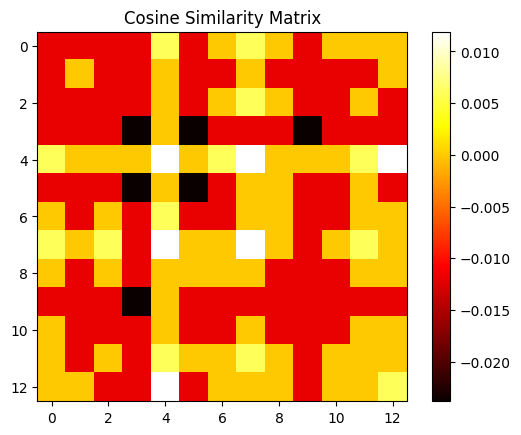

0 (3eytpBOkOFA.mp3) -> 1 (4n9Ie3ac6BM.mp3) - 100.01%
1 (4n9Ie3ac6BM.mp3) -> 0 (3eytpBOkOFA.mp3) - 100.01%
2 (6uR_UxqGoug.mp3) -> 0 (3eytpBOkOFA.mp3) - 100.01%
3 (9dKZeL2UbUM.mp3) -> 5 (Jj1_mfUzjOs.mp3) - 100.02%
4 (dr_GAJZviR0.mp3) -> 1 (4n9Ie3ac6BM.mp3) - 100.00%
5 (Jj1_mfUzjOs.mp3) -> 3 (9dKZeL2UbUM.mp3) - 100.02%
6 (kJQP7kiw5Fk.mp3) -> 1 (4n9Ie3ac6BM.mp3) - 100.01%
7 (OIBODIPC_8Y.mp3) -> 3 (9dKZeL2UbUM.mp3) - 100.01%
8 (OPf0YbXqDm0.mp3) -> 1 (4n9Ie3ac6BM.mp3) - 100.01%
9 (phuiiNCxRMg.mp3) -> 3 (9dKZeL2UbUM.mp3) - 100.02%
10 (t3kOeUsnocg.mp3) -> 1 (4n9Ie3ac6BM.mp3) - 100.01%
11 (Y4nEEZwckuU.mp3) -> 1 (4n9Ie3ac6BM.mp3) - 100.01%
12 (ZncbtRo7RXs.mp3) -> 2 (6uR_UxqGoug.mp3) - 100.01%


In [31]:
res = cosine_similarity(features)
p_res = res**1000
print(p_res)

show_matrix(musics, p_res)